In [37]:
import polars as pl
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy.sparse import csr_matrix
os.chdir(os.path.expanduser('~/vEcoli'))

In [38]:
def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

# data from Cyrus:
Cmatrix = read_matrix("notebooks/mia_notebooks/protein_count_comparison_files/C_matrix.csv", sparse=True)
complex_ids = list(read_names("notebooks/mia_notebooks/protein_count_comparison_files/complex_ids.txt"))
monomer_ids = list(read_names("notebooks/mia_notebooks/protein_count_comparison_files/monomer_ids.txt"))

# Ecocyc data (https://ecocyc.org/groups?tab=SPECIAL&orgid=ECOLI): 
ecocyc_data = pd.read_excel("notebooks/mia_notebooks/protein_count_comparison_files/All_polypeptides_from_ecocyc_data.xlsx")

# validation data (https://www.sciencedirect.com/science/article/pii/S0092867414002323?via%3Dihub#app1):
validation_data = pd.read_excel("notebooks/mia_notebooks/protein_count_comparison_files/data_from_li_et_al_2014.xlsx")

## Rich Media Conditions Comparison: Simulation data VS "MOPS complete" data from Li et al., 2014 


In [39]:
# simulation from 2024-06-13 (created with the vivarium-ecoli model, and it does produce an output on the new vEcoli model)
# time = '1300'
# date = '2024-06-13'
# experiment = 'metabolism-redux-classic-rich'
# entry = f'{experiment}_{time}_{date}'
# folder = f'out/cofactors/{entry}/'

In [40]:
time = '1300'
date = '2024-07-16'
experiment = 'metabolism-redux-classic-rich'
#experiment = 'validation_experiment'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

In [41]:
output_all = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output_all['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
rm_bulk = pl.DataFrame(output['bulk'])

fluxes = np.array(fba['estimated_fluxes'][1:])
exchanges = fba['estimated_exchange_dmdt']

ans = output['listeners']['unique_molecule_counts']['active_ribosome']

In [42]:
# So say I want to find the names of the proteins themselves, these are functions to implement that do so: 
initial_state = json.load(open('data/wcecoli_t0.json'))

bulk_ids = [item[0] for item in initial_state['bulk']]

rm_bulk.columns = bulk_ids

In [43]:
# Combine monomers in different compartments into one monomer id: 
id_idx_dict = {id: i for i, id in enumerate(bulk_ids)}
idx_id_dict = {idx: i for i, idx in id_idx_dict.items()}

# take the protein [location] out of the name of the bulk ids: 
ecocyc_ids = []
for id in bulk_ids: 
	ecocyc_ids.append(id[0:-3])

ecocyc_id_idxs = []
for i in range(len(ecocyc_ids)):
	ecocyc_id_idxs.append(i)
	
all_names = [] # ends with 12726 total (down from 16097)
name_groups = []
idx_groups = []

for p in bulk_ids:
	prot = p[0:-3]
	if prot not in all_names:
		indexes = [index for index, item in enumerate(ecocyc_ids) if item == prot]
		for idx in indexes:
			if ecocyc_ids[idx] == prot:
				# confirm the index is correct
				pass
			else:
				# delete the index in case a mistake was made
				indexes.remove(idx)
		name_group = [idx_id_dict.get(name) for name in indexes]
		all_names.append(prot)
		name_groups.append(name_group)
		idx_groups.append(indexes)
		
len(all_names)
len(name_groups)

12788

In [44]:
# figure out which proteins from the C matrix match those in the bulk data: 
protein_ids = complex_ids + monomer_ids
protein_counts = np.zeros([rm_bulk.shape[0], len(protein_ids)])
pid_idx_dict = {id: i for i, id in enumerate(protein_ids)}
idx_pid_dict = {idx: i for i, idx in pid_idx_dict.items()}

for p in protein_ids:
	idx = [index for index, item in enumerate(all_names) if item == p]
	if len(idx) == 0:
		protein_counts[:, pid_idx_dict[p]] = 0
	elif len(idx) == 1:
		name = all_names[idx[0]]
		idx_group = idx_groups[idx[0]]
		temp_counts = np.zeros([rm_bulk.shape[0], len(idx_group)])
		for i in range(len(idx_group)):
			selected_data = rm_bulk.select(bulk_ids[idx_group[i]]) 
			temp_counts[:, i] = selected_data.to_numpy().flatten()
		protein_counts[:, pid_idx_dict[p]] = np.sum(temp_counts, axis=1)
	else:
		# make sure there are no bugs in the code
		print(p)
		print("too many")
	

In [45]:
np.shape(protein_counts)


(1301, 5527)

In [46]:
rm_sim_protein_counts = protein_counts @ Cmatrix
# simplify the results accordingly with the time steps: 
rm_avg_sim_data = rm_sim_protein_counts.mean(axis=0)
# TODO: edit this to account for cell age
# create dataframes for the simulation data:
rm_avg_sim_df = pl.DataFrame((monomer_ids, rm_avg_sim_data), schema=["Monomer ID","Sim Protein Counts"])

In [47]:
rm_df = pl.DataFrame(ecocyc_data).join(rm_avg_sim_df,  how="inner", left_on="Proteins", right_on="Monomer ID")
rm_df

Proteins,Genes,Accession-1 of Gene,Common-Name,Sim Protein Counts
str,str,str,str,f64
"""EG11817-MONOMER""","""EG11817""","""b2744""","""umpG""",186.411222
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",937.099923
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",72.946964
"""G6991-MONOMER""","""G6991""","""b1807""","""tsaB""",547.750961
"""ADENODEAMIN-MONOMER""","""EG10030""","""b1623""","""add""",364.110684
…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",195.53651
"""GALACTITOLPDEHYD-MONOMER""","""EG12417""","""b2091""","""gatD""",846.579554
"""EG10736-MONOMER""","""EG10736""","""b0708""","""phr""",40.270561


In [48]:
# Remove rows from validation_data that do not have high confidence (they will contain brackets) in the "MOPS complete" column:
validation_data['MOPS complete'] = validation_data['MOPS complete'].astype(str)
validation_data = validation_data[~validation_data['MOPS complete'].str.contains("[", regex=False)]
validation_data = validation_data[validation_data['MOPS complete'].str.isdigit()]
validation_data['MOPS complete'] = validation_data['MOPS complete'].astype(int)
v_rm_data = validation_data[['Gene', 'MOPS complete']]
v_rm_data = pl.DataFrame(v_rm_data)
v_rm_data

Gene,MOPS complete
str,i64
"""aaeA""",62
"""aaeB""",16
"""aaeR""",203
"""aas""",188
"""aat""",151
…,…
"""zraR""",98
"""zraS""",8
"""zupT""",407


In [49]:
# find matches between the simulation minimal media data and validation minimal media data: 
vs_match_rm_df = pl.DataFrame(rm_df).join(v_rm_data,  how="inner", left_on="Common-Name", right_on="Gene")
vs_match_rm_df

Proteins,Genes,Accession-1 of Gene,Common-Name,Sim Protein Counts,MOPS complete
str,str,str,str,f64,i64
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",937.099923,827
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",72.946964,221
"""ADENODEAMIN-MONOMER""","""EG10030""","""b1623""","""add""",364.110684,724
"""EG10875-MONOMER""","""EG10875""","""b3310""","""rplN""",23871.555726,118153
"""G6605-MONOMER""","""G6605""","""b1165""","""ymgA""",157.213682,48
…,…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",195.53651,45
"""GALACTITOLPDEHYD-MONOMER""","""EG12417""","""b2091""","""gatD""",846.579554,643
"""EG10736-MONOMER""","""EG10736""","""b0708""","""phr""",40.270561,21


In [50]:
# make a new data frame that holds just the protein names and the Sim Protein Counts and MOPS minimal data and then filter out counts that are less than 10: 
rm_comparison_data = ["Proteins", "Sim Protein Counts", "MOPS complete"]
rm_comparison_df = vs_match_rm_df.select(rm_comparison_data)
rm_comparison_df = rm_comparison_df.rename({"Proteins": "Protein ID"})
rm_comparison_df = rm_comparison_df.filter((pl.col("Sim Protein Counts") > 10) & (pl.col("MOPS complete") > 10))
rm_comparison_df

Protein ID,Sim Protein Counts,MOPS complete
str,f64,i64
"""MONOMER0-4534""",937.099923,827
"""FDOI-MONOMER""",72.946964,221
"""ADENODEAMIN-MONOMER""",364.110684,724
"""EG10875-MONOMER""",23871.555726,118153
"""G6605-MONOMER""",157.213682,48
…,…,…
"""G7835-MONOMER""",195.53651,45
"""GALACTITOLPDEHYD-MONOMER""",846.579554,643
"""EG10736-MONOMER""",40.270561,21


In [51]:
np.shape(rm_comparison_df)

(2649, 3)

Text(0.5, 1.0, 'Comparisons of E.coli Protein Counts in Rich Media \n from Literature Data (Li, et. al., 2014) and Simulation Data')

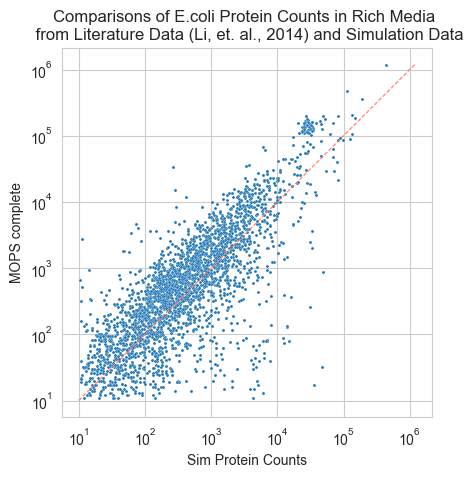

In [52]:
# plot the comparison graph:
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=rm_comparison_df.to_pandas(), s=5)

# find the max value of the plot for making a y=x line: 
max_vals = [max(rm_comparison_df["Sim Protein Counts"]), max(rm_comparison_df["MOPS complete"])]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1); 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of E.coli Protein Counts in Rich Media \n from Literature Data (Li, et. al., 2014) and Simulation Data")

## normalization of the data

Normalize by calculating the sum of the Sim Protein counts and the MOPS complete counts and then dividing each value by the total sum of the respective counts.
To normalize to one, also multiply the ((MOPS complete)/(total MOPS complete counts) by the total sum of the Sim Protein counts.

Thus, normalized would look like this: 
normalized Sim Protein Counts: $$Sim Protein Counts$$
normalized MOPS complete Counts: $$\frac{MOPS complete}{\sum_{i=1}^{n} MOPS complete} \times \sum_{i=1}^{n} Sim Protein Counts$$


In [67]:
# get the sum of the total sim protein counts and the total MOPS complete counts:
total_sim_protein_counts = rm_comparison_df["Sim Protein Counts"].sum()
total_mops_complete_counts = rm_comparison_df["MOPS complete"].sum()

# normalize the data:
rm_comparison_df = rm_comparison_df.with_columns(
	((rm_comparison_df["Sim Protein Counts"] )).alias("Sim Protein Counts"),
	((rm_comparison_df["MOPS complete"] / total_mops_complete_counts) * total_sim_protein_counts).alias("MOPS complete"))

Text(0.5, 1.0, 'Comparisons of E.coli Protein Counts in Rich Media \n from Literature Data (Li, et. al., 2014) and Simulation Data')

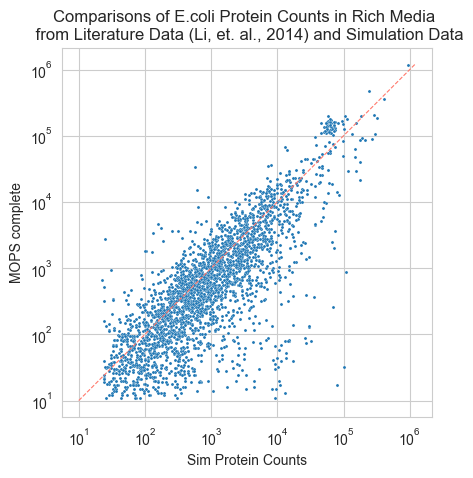

In [80]:
# plot the comparison graph:
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=rm_comparison_df.to_pandas(), s=5)

# find the max value of the plot for making a y=x line: 
max_vals = [max(rm_comparison_df["Sim Protein Counts"]), max(rm_comparison_df["MOPS complete"])]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1); 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of $\t{E. coli}$ Protein Counts in Rich Media \n from Literature Data (Li, et. al., 2014) and Simulation Data")

In [68]:
# plot the comparison graph with plotly:
df = rm_comparison_df.to_pandas()
fig = px.scatter(df, x=df["Sim Protein Counts"],y=df["MOPS complete"], hover_data=["Protein ID"], trendline="ols" )
fig.add_trace(go.Scatter(x=[0, max_val], y=[0, max_val], mode="lines",
        line=go.scatter.Line(color="red", dash="dash"),
        showlegend=False));

fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.update_layout(title="Comparisons of E.coli Protein Counts in Rich Media\nfrom Literature Data (Li, et. al., 2014) and Simulation Data")
# make the figure square and have equal axis numbers
fig.update_layout(width=800, height=800)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
  )
fig.show()

## Test out changing the color of the points based on the protein name

In [69]:
# load in data frame that lists protein + metal ion interations:
protein_metal_data = pd.read_csv("notebooks/mia_notebooks/protein_count_comparison_files/metal_protein_interaction_df.csv")
protein_metal_data

# todo: note this data has way more proteins than the comparison data has becuase it also has all the complexes listed!

,FE,ZN,MN,CU,MO,NI,CO,Protein ID
0,0,0,0,0,0,0,0,1-PFK
1,0,0,0,0,0,0,0,2OXOGLUTARATEDEH-CPLX
2,0,0,0,0,0,0,0,3-ISOPROPYLMALDEHYDROG-CPLX
3,4,0,0,0,0,0,0,3-ISOPROPYLMALISOM-CPLX
4,0,0,0,0,0,0,0,3-METHYL-2-OXOBUT-OHCH3XFER-CPLX
...,...,...,...,...,...,...,...,...
5522,0,0,0,0,0,0,0,YTFR-MONOMER
5523,0,0,0,0,0,0,0,YTFT-MONOMER
5524,0,1,0,0,0,0,0,ZNUA-MONOMER
5525,0,0,0,0,0,0,0,ZNUB-MONOMER


In [70]:
# DETERMINE WHICH PROTEINS HAVE METAL INTERACTIONS

# determine which proteins in the comparison data have metal interactions and which do not:
interaction_df = pl.DataFrame(protein_metal_data[["Protein ID", "FE", "ZN", "MN", "CU", "MO", "NI", "CO"]])

# find the proteins that are cross listed between the comparison data and the metal interaction data:
def find_cross_listed_proteins(interaction_df, comparison_df):
	# Filter out proteins with metal interactions:
	cross_listed_df = pl.DataFrame(comparison_df).join(interaction_df, how="inner", on="Protein ID")
	cross_listed_df = cross_listed_df.drop(["Sim Protein Counts", "MOPS complete"])
	return cross_listed_df

# find the proteins that are in the dataset and have metal interactions: 
cross_listed_df = find_cross_listed_proteins(interaction_df, rm_comparison_df)

# Define the columns of interest
metal_columns = ['FE', 'ZN', 'MN', 'CU', 'MO', 'NI', 'CO']

# Add a new column that counts the nonzero values for each Protein ID across the metal columns
cross_listed_df_with_counts = cross_listed_df.with_columns(
    (pl.sum_horizontal([pl.col(col) != 0 for col in metal_columns])).alias("nonzero_count"))
cross_listed_df_with_counts

Protein ID,FE,ZN,MN,CU,MO,NI,CO,nonzero_count
str,i64,i64,i64,i64,i64,i64,i64,u32
"""1-ACYLGLYCEROL-3-P-ACYLTRANSFE…",0,0,0,0,0,0,0,0
"""1-PFK-MONOMER""",0,0,0,0,0,0,0,0
"""2-DEHYDROPANTOATE-REDUCT-MONOM…",0,0,0,0,0,0,0,0
"""2-ISOPROPYLMALATESYN-MONOMER""",0,0,0,0,0,0,0,0
"""2-OCTAPRENYL-METHOXY-BENZOQ-ME…",0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…
"""YRBG-MONOMER""",0,0,0,0,0,0,0,0
"""YTFQ-MONOMER""",0,0,0,0,0,0,0,0
"""ZNUA-MONOMER""",0,1,0,0,0,0,0,1


## Plot #1) Proteins with Metal Interactions

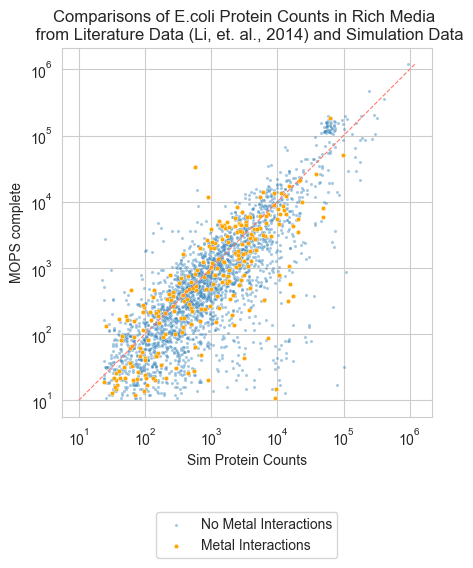

In [71]:
# find proteins that have at least one interaction: 
proteins_with_interactions = cross_listed_df_with_counts.filter(pl.col("nonzero_count") > 0)
proteins_with_interactions = proteins_with_interactions.join(rm_comparison_df, how="inner", on="Protein ID")

# find proteins with no interactions:
no_interactions_df = cross_listed_df.filter(~pl.col("Protein ID").is_in(proteins_with_interactions["Protein ID"]))
no_interactions_df = no_interactions_df.join(rm_comparison_df, how="inner", on="Protein ID")

# plot the comparison graph with proteins that have metal interactions in red and proteins that do not have metal interactions in blue:
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=no_interactions_df.to_pandas(), s=5, alpha=.4)
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=proteins_with_interactions.to_pandas(), s=10, color="orange")
# find the max value of the plot for making a y=x line: 
max_vals = [max(rm_comparison_df["Sim Protein Counts"]), max(rm_comparison_df["MOPS complete"])]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1) 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of $\t{E. coli}$ Protein Counts in Rich Media \n from Literature Data (Li, et. al., 2014) and Simulation Data")
plt.legend(["No Metal Interactions", "Metal Interactions"], bbox_to_anchor=(.5, -.4), loc='lower center')

## Plot #2) Proteins with Metal Interactions (by number of interactions)

In [72]:
# find the max number of interactions a protein has:
max_interactions = max(cross_listed_df_with_counts["nonzero_count"])
max_interactions

2

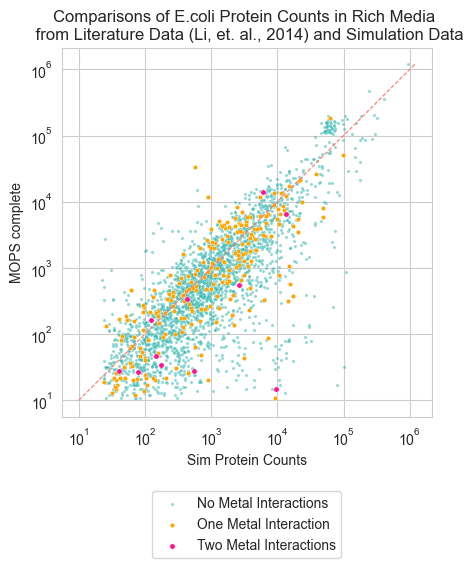

In [73]:
# already have dataframe for proteins with no interactions, but find the rest: 
one_interaction = cross_listed_df_with_counts.filter(pl.col("nonzero_count") == 1) # gives 525 rows
one_interaction = one_interaction.join(rm_comparison_df, how="inner", on="Protein ID")
two_interactions = cross_listed_df_with_counts.filter(pl.col("nonzero_count") == 2) # gives 40 rows
two_interactions = two_interactions.join(rm_comparison_df, how="inner", on="Protein ID")

# plot the comparison graph with proteins that have metal interactions in red and proteins that do not have metal interactions in blue:
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=no_interactions_df.to_pandas(), s=5, color='lightseagreen', alpha=.5)
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=one_interaction.to_pandas(), s=10, color="orange")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=two_interactions.to_pandas(), s=15, color="deeppink")

# find the max value of the plot for making a y=x line: 
max_vals = [max(rm_comparison_df["Sim Protein Counts"]), max(rm_comparison_df["MOPS complete"])]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1) 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of $\t{E. coli}$ Protein Counts in Rich Media \n from Literature Data (Li, et. al., 2014) and Simulation Data")
plt.legend(["No Metal Interactions", "One Metal Interaction", "Two Metal Interactions"], bbox_to_anchor=(.5, -.4), loc='lower center')

## Plot #3) Proteins with Metal Interactions (by metal type)

In [74]:
# FUNCTIONS

# find the proteins that have Iron (Fe) interactions:
def find_Fe_interactions(interaction_df):
	Fe_filtered = interaction_df.filter(pl.col("FE") > 0)
	Fe_df = Fe_filtered.select(pl.col(["Protein ID", "FE"]))
	return Fe_df

# find the proteins that have Zinc (Zn) interactions:
def find_Zn_interactions(interaction_df):
	Zn_filtered = interaction_df.filter(pl.col("ZN") > 0)
	Zn_df = Zn_filtered.select(pl.col(["Protein ID", "ZN"]))
	return Zn_df

# find the proteins that have Manganese (Mn) interactions:
def find_Mn_interactions(interaction_df):
	Mn_filtered = interaction_df.filter(pl.col("MN") > 0)
	Mn_df = Mn_filtered.select(pl.col(["Protein ID", "MN"]))
	return Mn_df

# find the proteins that have Copper (Cu) interactions:
def find_Cu_interactions(interaction_df):
	Cu_filtered = interaction_df.filter(pl.col("CU") > 0)
	Cu_df = Cu_filtered.select(pl.col(["Protein ID", "CU"]))
	return Cu_df

# find the proteins that have Molybdenum (Mo) interactions:
def find_Mo_interactions(interaction_df):
	Mo_filtered = interaction_df.filter(pl.col("MO") > 0)
	Mo_df = Mo_filtered.select(pl.col(["Protein ID", "MO"]))
	return Mo_df

# find the proteins that have Nickel (Ni) interactions:
def find_Ni_interactions(interaction_df):
	Ni_filtered = interaction_df.filter(pl.col("NI") > 0)
	Ni_df = Ni_filtered.select(pl.col(["Protein ID", "NI"]))
	return Ni_df

# find the proteins that have Cobalt (Co) interactions:
def find_Co_interactions(interaction_df):
	Co_filtered = interaction_df.filter(pl.col("CO") > 0)
	Co_df = Co_filtered.select(pl.col(["Protein ID", "CO"]))
	return Co_df


In [75]:
# find the metal interaction for the proteins with just one interaction: 
Fe_df = find_Fe_interactions(one_interaction); Fe_df = Fe_df.join(rm_comparison_df, how="inner", on="Protein ID")
Zn_df = find_Zn_interactions(one_interaction); Zn_df = Zn_df.join(rm_comparison_df, how="inner", on="Protein ID")
Mn_df = find_Mn_interactions(one_interaction); Mn_df = Mn_df.join(rm_comparison_df, how="inner", on="Protein ID")
Cu_df = find_Cu_interactions(one_interaction); Cu_df = Cu_df.join(rm_comparison_df, how="inner", on="Protein ID")
Mo_df = find_Mo_interactions(one_interaction); Mo_df = Mo_df.join(rm_comparison_df, how="inner", on="Protein ID")
Ni_df = find_Ni_interactions(one_interaction); Ni_df = Ni_df.join(rm_comparison_df, how="inner", on="Protein ID")
Co_df = find_Co_interactions(one_interaction); Co_df = Co_df.join(rm_comparison_df, how="inner", on="Protein ID")

# find the metal interaction for the proteins with two interactions:
Fe_df2 = find_Fe_interactions(two_interactions)
Zn_df2 = find_Zn_interactions(two_interactions)
Mn_df2 = find_Mn_interactions(two_interactions)
Cu_df2 = find_Cu_interactions(two_interactions)
Mo_df2 = find_Mo_interactions(two_interactions)
Ni_df2 = find_Ni_interactions(two_interactions)
Co_df2 = find_Co_interactions(two_interactions)

# figure out which proteins have two interactions and sort them (since each only has 2 max, this should be not too difficult):
def remove_proteins(dfs, proteins_to_remove):
	for df in dfs:
		for protein_id in proteins_to_remove:
			df = df.filter(pl.col("Protein ID") != protein_id)
	

df2_list = [Fe_df2, Zn_df2, Mn_df2, Cu_df2, Mo_df2, Ni_df2, Co_df2]

# find proteins that have a match between the Fe and Zn Dataframes:
Fe_Zn_df = Fe_df2.join(Zn_df2, how="inner", on="Protein ID"); 
remove_proteins(df2_list, Fe_Zn_df["Protein ID"])

# find proteins that have a match between the Fe and Mn Dataframes:
Fe_Mn_df = Fe_df2.join(Mn_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Mn_df["Protein ID"])

# find proteins that have a match between the Fe and Cu Dataframes:
Fe_Cu_df = Fe_df2.join(Cu_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Cu_df["Protein ID"])

# find proteins that have a match between the Fe and Mo Dataframes:
Fe_Mo_df = Fe_df2.join(Mo_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Mo_df["Protein ID"])

# find proteins that have a match between the Fe and Ni Dataframes:
Fe_Ni_df = Fe_df2.join(Ni_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Ni_df["Protein ID"])

# find proteins that have a match between the Fe and Co Dataframes:
Fe_Co_df = Fe_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Co_df["Protein ID"])

# find proteins that have a match between the Zn and Mn Dataframes:
Zn_Mn_df = Zn_df2.join(Mn_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Mn_df["Protein ID"])

# find proteins that have a match between the Zn and Cu Dataframes:
Zn_Cu_df = Zn_df2.join(Cu_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Cu_df["Protein ID"])

# find proteins that have a match between the Zn and Mo Dataframes:
Zn_Mo_df = Zn_df2.join(Mo_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Mo_df["Protein ID"])

# find proteins that have a match between the Zn and Ni Dataframes:
Zn_Ni_df = Zn_df2.join(Ni_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Ni_df["Protein ID"])

# find proteins that have a match between the Zn and Co Dataframes:
Zn_Co_df = Zn_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Co_df["Protein ID"])

# find proteins that have a match between the Mn and Cu Dataframes:
Mn_Cu_df = Mn_df2.join(Cu_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mn_Cu_df["Protein ID"])

# find proteins that have a match between the Mn and Mo Dataframes:
Mn_Mo_df = Mn_df2.join(Mo_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mn_Mo_df["Protein ID"])

# find proteins that have a match between the Mn and Ni Dataframes:
Mn_Ni_df = Mn_df2.join(Ni_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mn_Ni_df["Protein ID"])

# find proteins that have a match between the Mn and Co Dataframes:
Mn_Co_df = Mn_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mn_Co_df["Protein ID"])
	
# find proteins that have a match between the Cu and Mo Dataframes:
Cu_Mo_df = Cu_df2.join(Mo_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Cu_Mo_df["Protein ID"])
	
# find proteins that have a match between the Cu and Ni Dataframes:
Cu_Ni_df = Cu_df2.join(Ni_df2, how="inner", on="Protein ID");

# find proteins that have a match between the Cu and Co Dataframes:
Cu_Co_df = Cu_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Cu_Co_df["Protein ID"])

# find proteins that have a match between the Mo and Ni Dataframes:
Mo_Ni_df = Mo_df2.join(Ni_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mo_Ni_df["Protein ID"])

# find proteins that have a match between the Mo and Co Dataframes:
Mo_Co_df = Mo_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mo_Co_df["Protein ID"])

# find proteins that have a match between the Ni and Co Dataframes:
Ni_Co_df = Ni_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Ni_Co_df["Protein ID"])
	
# find proteins that have a match between the Ni and Co Dataframes:
Ni_Co_df = Ni_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Ni_Co_df["Protein ID"])

# find the proteins that have more than one metal interaction:
check = Fe_df2.join(Zn_df2, how="inner", on="Protein ID")
check = check.join(Mn_df2, how="inner", on="Protein ID")
check = check.join(Cu_df2, how="inner", on="Protein ID")
check = check.join(Mo_df2, how="inner", on="Protein ID")
check = check.join(Ni_df2, how="inner", on="Protein ID")
check = check.join(Co_df2, how="inner", on="Protein ID")
check # should be empty

Protein ID,FE,ZN,MN,CU,MO,NI,CO
str,i64,i64,i64,i64,i64,i64,i64


In [76]:
# find which have nonzero values: 
print(np.shape(Fe_Zn_df), np.shape(Fe_Mn_df), np.shape(Fe_Cu_df), np.shape(Fe_Mo_df), np.shape(Fe_Ni_df), np.shape(Fe_Co_df))
print(np.shape(Zn_Mn_df), np.shape(Zn_Cu_df), np.shape(Zn_Mo_df), np.shape(Zn_Ni_df), np.shape(Zn_Co_df))
print(np.shape(Mn_Cu_df), np.shape(Mn_Mo_df), np.shape(Mn_Ni_df), np.shape(Mn_Co_df))
print(np.shape(Cu_Mo_df), np.shape(Cu_Ni_df), np.shape(Cu_Co_df))
print(np.shape(Mo_Ni_df), np.shape(Mo_Co_df))
print(np.shape(Ni_Co_df))


(3, 3) (0, 3) (1, 3) (2, 3) (0, 3) (0, 3)
(1, 3) (1, 3) (0, 3) (2, 3) (1, 3)
(0, 3) (0, 3) (0, 3) (0, 3)
(0, 3) (0, 3) (0, 3)
(0, 3) (0, 3)
(0, 3)


In [77]:
df_list = []
df_combos = []
for protein in two_interactions["Protein ID"]:
	name_options = [ "FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
	protein_row = two_interactions.filter(pl.col("Protein ID") == protein)
	Fe_val = protein_row["FE"].to_numpy()[0]
	Zn_val = protein_row["ZN"].to_numpy()[0]
	Mn_val = protein_row["MN"].to_numpy()[0]
	Cu_val = protein_row["CU"].to_numpy()[0]
	Mo_val = protein_row["MO"].to_numpy()[0]
	Ni_val = protein_row["NI"].to_numpy()[0]
	Co_val = protein_row["CO"].to_numpy()[0]
	values = [Fe_val, Zn_val, Mn_val, Cu_val, Mo_val, Ni_val, Co_val]
	values_idx = np.nonzero(values)
	df_names = [name_options[i] for i in values_idx[0]]
	df_name = "_".join(df_names)
	protein_row= protein_row.with_columns(
        pl.lit(df_name).alias("Metal Interactions")) 
	if df_name not in df_combos:
		df_combos.append(df_name)
		df_list.append(protein_row)
	else: 
		df_list[df_combos.index(df_name)] = df_list[df_combos.index(df_name)].vstack(protein_row)

df_combos

['FE_MO', 'FE_ZN', 'ZN_MN', 'ZN_NI', 'ZN_CO', 'FE_CU', 'ZN_CU']

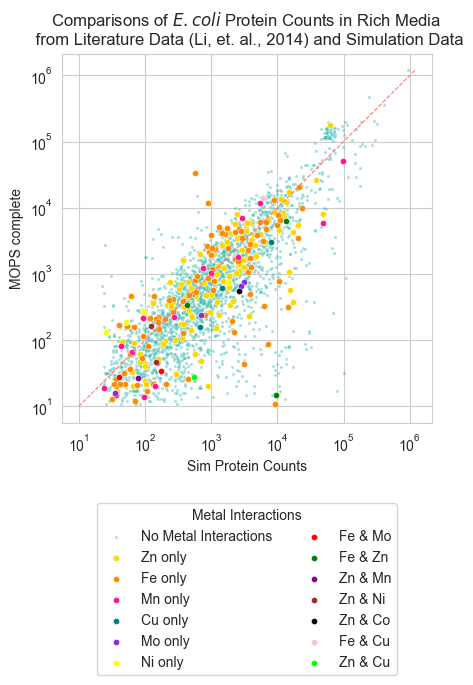

In [81]:
# plot the comparison graph with proteins that have metal interactions in red and proteins that do not have metal interactions in blue:
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=no_interactions_df.to_pandas(), s=5, alpha=0.4, color="lightseagreen")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=Zn_df.to_pandas(), s=20, color="gold")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=Fe_df.to_pandas(), s=20, color="darkorange")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=Mn_df.to_pandas(), s=20, color="deeppink")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=Cu_df.to_pandas(), s=20, color="teal")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=Mo_df.to_pandas(), s=20, color="blueviolet")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=Ni_df.to_pandas(), s=20, color="yellow")
#sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=Co_df.to_pandas(), s=20, color="cyan") # no Co only!
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=df_list[0].to_pandas(), s=20, color="red")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=df_list[1].to_pandas(), s=20, color="green")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=df_list[2].to_pandas(), s=20, color="purple")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=df_list[3].to_pandas(), s=20, color="brown")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=df_list[4].to_pandas(), s=20, color="black")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=df_list[5].to_pandas(), s=20, color="pink")
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=df_list[6].to_pandas(), s=20, color="lime")

# find the max value of the plot for making a y=x line: 
max_vals = [max(rm_comparison_df["Sim Protein Counts"]), max(rm_comparison_df["MOPS complete"])]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1) 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of $\t{E. coli}$ Protein Counts in Rich Media \n from Literature Data (Li, et. al., 2014) and Simulation Data")
plt.legend(["No Metal Interactions", "Zn only", "Fe only", "Mn only", "Cu only", "Mo only", "Ni only", 'Fe & Mo', 'Fe & Zn', 'Zn & Mn', 'Zn & Ni', 'Zn & Co', 'Fe & Cu', 'Zn & Cu'], title="Metal Interactions",bbox_to_anchor=(.5, -.7), loc='lower center',ncol=2)

In [79]:
Zn_df # 110
Fe_df # 91
Mn_df # 16
Cu_df # 3
Mo_df # 4
Ni_df # 4
Co_df # 0 

Protein ID,CO,Sim Protein Counts,MOPS complete
str,i64,f64,f64
